# PIXAL: A Physics-Informed Explainable Machine Learning Model for Predicting Greenland Ice Albedo

#### A significant portion of the acceleration of the global mean sea level (GMSL) rise over the last few decades has been attributed to increased surface melting from the Greenland ice sheet (GrIS) (Aschwanden et al., 2019). Climate models project a contribution of 9-18 cm from the GrIS by 2100 for the Shared Socioeconomic Pathway SSP5-8.5 (Fox-Kemper et al., 2021; Riahi et al., 2017). The significant uncertainty in this projection hinders accurate and effective mitigation of the implications of sea level change on coastal communities. The uncertainty stems largely from a not-complete understanding of the physical processes that control ice surface melting on the GrIS. Specifically, we lack understanding of the spatiotemporal variability and evolution of ice albedo, which plays a crucial role in ice surface melt processes.

#### Ice is exposed on the GrIS during the summer melting season (June-August) when increased insolation and surface temperature induce melting over the snowpack overlying the ice. Snow melt generally occurs at the ice sheet margin at lower elevations in the ablation zone. Here, the surface mass balance (SMB) is negative, when snow and ice ablation (melting, evaporation, and sublimation) is larger than accumulation (snow, rainfall, and refreezing), resulting in a net loss of mass through surface processes. In this study, we focus on broadband ice albedo, which represents the fraction of incoming solar radiation that is absorbed by the ice as a wavelength-weighted hemispheric average (Warren and Wiscombe, 1980; Wiscombe and Warren, 1980). Ice albedo on the GrIS is a highly complex property of the ice surface that is controlled by the metamorphic state of the ice, environmental and radiative conditions, and the presence of meltwater ponds and light-absorbing consistuents, such as dust, black carbon, and algae. The complexity of the high number of drivers and non-linear feedbacks that affect ice albedo variability hinder the development of a comprehensive and predictive ice albedo model that accurately accounts for these processes, leading to inaccurate predictions of surface melting and sea level rise.

#### We adopt a machine learning approach to model the ice albedo variability. In this study, we focus on the southwestern GrIS, the area currently responsible for the majority of meltwater production (Steger et al., 2017). We use optical remote sensing data and previously unused regional climate model output to train an ML model to accurately simulate ice albedo.

#### PIXAL is the first-ever physics-informed explainable machine learning model capable of accurately predicting ice albedo on the Greenland Ice Sheet. It significantly outperfoms current state-of-the-art climate models.
#### Improved R^2 from 0.053 to 0.520
#### Improved MSE from 0.031 to 0.0057
#### Improved MAPE from 45.933% to 15.295%
#### Improved SSIM from 0.083 to 0.595

# Import libraries

In [ ]:
pip install tensorflow optuna optuna-dashboard xgboost shap

In [ ]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
import io
import os
from PIL import Image
import seaborn as sns
import richdem as rd

import tensorflow as tf
import tensorflow.math
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.datasets
import sklearn.metrics
from sklearn.metrics import *
from skimage.metrics import structural_similarity as ssim

import optuna
import xgboost as xgb
from xgboost import XGBRegressor

import shap
import pickle
import random

import cartopy
import cartopy.crs as ccrs
from matplotlib.image import imread
import matplotlib.ticker as mticker

fname = os.path.join('./', 'NE1_50M_SR_W.tif')
plt.rcParams['figure.figsize'] = (12,12)

# Load regional climate model (MAR) output over the Greenland Ice Sheet

#### Load local MAR output for 2020 on 6.5km

In [6]:
url = 'gs://leap-persistent/raf-antwerpen/MARv3.12-6_5km-daily-ERA5-2020.zarr'
ds2020 = xr.open_dataset(url, engine='zarr', chunks={})

#### Set parameters

In [7]:
jun1 = 151
aug31 = 242
numberdays = aug31-jun1+1
jun1_leap = jun1 + 1
aug31_leap = aug31 + 1

numberyears = 22
numberdaystot = numberyears * numberdays
n_feature = 23
n_lat = 415
n_lon = 230

In [8]:
LAT = ds2020.LAT.values
LON = ds2020.LON.values
LAT_SW = LAT[:int(n_lat/2), :int(n_lon/2)]
LON_SW = LON[:int(n_lat/2), :int(n_lon/2)]
AL2_2020 = ds2020.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]

#### Calculate slope and aspect of ice sheet

In [ ]:
SH_vals = rd.rdarray(ds2020.SH.values, no_data=-9999)

slope = rd.TerrainAttribute(SH_vals/1000, attrib='slope_degrees')
aspect = rd.TerrainAttribute(SH_vals, attrib='aspect')

In [ ]:
# This is the final input dataset

x = np.zeros((numberyears, numberdays, n_lat, n_lon, n_feature))

for i in range(22):
    print(i)
    year = i + 2000
    url = f"gs://leap-persistent/raf-antwerpen/MARv3.12-6_5km-daily-ERA5-{year}.zarr"
    ds = xr.open_dataset(url, engine='zarr', chunks={})

    x[i,:,:,:,0] = ds.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]
    x[i,:,:,:,1] = ds.TT.values[jun1:aug31+1,0,:n_lat,:n_lon]
    x[i,:,:,:,2] = ds.RU.values[jun1:aug31+1,0,:n_lat,:n_lon]
    x[i,:,:,:,3] = ds.SWU.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,4] = ds.SWD.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,5] = ds.LWU.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,6] = ds.LWD.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,7] = ds.SHF.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,8] = ds.LHF.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,9] = ds.CD.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,10] = ds.CM.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,11] = ds.CU.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,12] = ds.COD.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,13] = np.mean(ds.RO1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
    x[i,:,:,:,14] = ds.UU.values[jun1:aug31+1,0,:n_lat,:n_lon]
    x[i,:,:,:,15] = ds.VV.values[jun1:aug31+1,0,:n_lat,:n_lon]
    x[i,:,:,:,16] = ds.SU.values[jun1:aug31+1,0,:n_lat,:n_lon]
    x[i,:,:,:,17] = np.mean(ds.WA1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
    x[i,:,:,:,18] = ds.SF.values[jun1:aug31+1,:n_lat,:n_lon]
    x[i,:,:,:,19] = ds.RF.values[jun1:aug31+1,:n_lat,:n_lon]
    
    # repeat the same data for each day for SH, SOL, slope, aspect, algnan since they do not vary temporally.
    for j in range(aug31-jun1+1):
        x[i,j,:,:,20] = ds2020.SH.values[:n_lat,:n_lon]
        x[i,j,:,:,21] = slope[:n_lat,:n_lon]
        x[i,j,:,:,22] = aspect[:n_lat,:n_lon]

In [297]:
np.shape(x)

(22, 92, 415, 230, 23)

In [298]:
# only use lower left quadrant of Greenland ice sheet
x = x[:,:,:int(n_lat/2),:int(n_lon/2),:]
x = x.reshape(numberdaystot, int(n_lat/2), int(n_lon/2), 23)

In [300]:
# Only include data below 70 N
x2 = np.zeros((2024,207,115,23))
for i in range(23):
    x2[:,:,:,i] = np.where(LAT_SW>70, np.nan, x[:,:,:,i])
x = x2

In [301]:
# np.save('x.npy', x)

In [9]:
# x = np.load('./x.npy')

# Load MODIS albedo data

In [ ]:
path = './MOD10A1_albedo_MARproj_6_5km/'
dir_list = np.sort(os.listdir(path))
dir_list = dir_list[:]
dir_list

#### Create nan arrays for days where I don't have MODIS data

In [ ]:
modisnan = np.zeros((415,230))
modisnan = np.where(modisnan == 0, np.nan, np.nan)

#### Flip matrix right-side up and place in new matrix 'y'

In [ ]:
y = np.zeros((numberdaystot,415,230,1))

for i in range(65):
    f = dir_list[i]
    im = Image.open(path + f)
    y[i,:,:,0] = np.flipud(np.array(im))

for i in range(65,78):
    y[i,:,:,0] = modisnan

for i in range(78,107):
    f = dir_list[i-13]
    im = Image.open(path + f)
    y[i,:,:,0] = np.flipud(np.array(im))

for i in range(107,124):
    y[i,:,:,0] = modisnan

for i in range(124,numberdaystot):
    f = dir_list[i-29]
    im = Image.open(path + f)
    y[i,:,:,0] = np.flipud(np.array(im))

#### Turn 255's into NaNs, divide by 100 to get albedo in 0-1 range

In [ ]:
y = np.where(y == 255, np.nan, y)
y = y/100

#### Load bare ice variable (from Antwerpen et al., 2022). This variables gives 1's for bare ice and NaNs for non-bare ice (snow, land, or ocean) daily for June, July, and August in 2000-2021

In [41]:
ds_bie = sio.loadmat('./sboth_6km.mat')
bareice = np.flipud(ds_bie['sboth_6km'])
bareice = np.transpose(bareice, (2, 3, 0, 1))
bareice = bareice.reshape(numberdaystot, n_lat, n_lon)

#### Multiply with bare ice matrix to extract only bare ice albedo values

In [ ]:
y = y[:,:,:,0] * bareice

#### Only use southern half or southwest quadrant

In [ ]:
# only use lower left quadrant
y = y[:,:int(n_lat/2),:int(n_lon/2)]

In [ ]:
# np.save('y.npy', y)

In [10]:
# y = np.load('./y.npy')

In [11]:
# remove everyting above 70N
y2 = np.where(LAT_SW>70, np.nan, y)
y = y2

# Find 2-sigma ice albedo cut-off values for MODIS

In [12]:
y_mean = np.nanmean(y)
y_std = np.nanstd(y)
y_meanplus2sig = y_mean + 2 * y_std
y_meanminus2sig = y_mean - 2 * y_std

# Prepare data for training and testing

#### Create mask of valid albedo pixels and only use pixels (in x and y) that have a realistic albedo value (plusminus 2-sigma)

In [13]:
# only use MODIS albedo values within 2-sigma
y_masknan = np.where((y > y_meanminus2sig) & (y < y_meanplus2sig), 1, np.nan)

y_mask = y * y_masknan
x_mask = np.zeros((numberdaystot,x.shape[1],x.shape[2],x.shape[3]))
for i in range(x.shape[3]):
    x_mask[:,:,:,i] = x[:,:,:,i] * y_masknan[:,:,:]

#### Standardize the data so all values are in the 0-range, plusminus a couple (2-5).

In [14]:
x_dum = np.zeros((x.shape[0], x.shape[1], x.shape[2], x.shape[3]))
vars_mean = np.zeros((x.shape[3],1))
vars_std = np.zeros((x.shape[3],1))

for i in range(x.shape[3]):
    
    vars_mean[i], vars_std[i] = np.nanmean(x_mask[:,:,:,i]), np.nanstd(x_mask[:,:,:,i])
    
    x_dum[:,:,:,i]   = (x_mask[:,:,:,i] - vars_mean[i])/vars_std[i]

x_mask = x_dum

In [15]:
# get all non-nan values in y (where bareice==1) and put them in a 1D array
y_nonan = y_mask[~np.isnan(y_mask)]

# create zero matrix of same lenth as y_nonan, with space for all 23 features in x
x_nonan = np.zeros((450110,x.shape[3]))

# put values of x (where bareice==1) in x_nonan, for all MAR features
for i in range(x.shape[3]):
    x_mask_dum = x_mask[:,:,:,i]
    x_nonan[:,i] = x_mask_dum[~np.isnan(x_mask_dum)]

# Train, test, validation split

In [16]:
X_train1, X_test, y_train1, y_test = train_test_split(x_nonan, y_nonan, test_size=(2/22), shuffle=False)

In [17]:
X_train1.shape, X_test.shape, y_train1.shape, y_test.shape

((409190, 23), (40920, 23), (409190,), (40920,))

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=(2/20), shuffle=False)

In [19]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((368271, 23), (40919, 23), (368271,), (40919,))

#### AL2 (albedo) should not be used in the model training phase, so remove AL2 from X_test and move to X_test_AL2. Do the same for X_train1, X_train, and X_val

In [20]:
X_test_AL2 = X_test[:,0]
X_test_temp = np.zeros((X_test.shape[0],22))
X_test_temp[:,:] = X_test[:,1:]
X_test = X_test_temp

X_train1_AL2 = X_train1[:,0]
X_train1_temp = np.zeros((X_train1.shape[0],22))
X_train1_temp[:,:] = X_train1[:,1:]
X_train1 = X_train1_temp

X_train_AL2 = X_train[:,0]
X_train_temp = np.zeros((X_train.shape[0],22))
X_train_temp[:,:] = X_train[:,1:]
X_train = X_train_temp

X_val_AL2 = X_val[:,0]
X_val_temp = np.zeros((X_val.shape[0],22))
X_val_temp[:,:] = X_val[:,1:]
X_val = X_val_temp

In [21]:
# create mean and std for AL2
AL2_mean = vars_mean[0]
AL2_std = vars_std[0]

In [22]:
# create mean and std for all MAR features
vars_mean_temp = np.zeros((vars_mean.shape[0]-1))
vars_mean_temp[:] = vars_mean[1:,0]
vars_mean = vars_mean_temp

vars_std_temp = np.zeros((vars_std.shape[0]-1))
vars_std_temp[:] = vars_std[1:,0]
vars_std = vars_std_temp

# Hyper-parameter tuning

In [323]:
# 1. Define an objective function to be maximized.
def objective(trial):
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    
    # 2. Suggest values of the hyperparameters using a trial object.
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": trial.suggest_categorical("tree_method", ["exact", "approx", "hist"]),
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-2, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-2, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        # learning rate
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 13, 61, step=4)
        # maximum number of nodes. not used by 'exact' tree method
        param["max_leaves"] = trial.suggest_int("max_leaves", 0, 8, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 20)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1e-6, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    mse = sklearn.metrics.mean_squared_error(y_val, pred_labels)
    
    return mse

In [ ]:
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize", storage="sqlite:///db.sqlite3", study_name="run1-new_vars_20240216")
    study.optimize(objective, n_trials=50000, timeout=3600*20)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

# Initialize and run XGB model

In [23]:
# best parameters from optuna
bst = XGBRegressor(n_estimators=500,
                    
                tree_method='exact',
                booster='gbtree',
                reg_lambda=0.3287118009045606,
                reg_alpha=0.7440627579790412,
                subsample=0.9195230884303485,
                colsample_bytree=0.7931278468655109,
                learning_rate=0.0668398512735129,
                max_depth=21,
                min_child_weight=10,
                gamma=2.380218360212393e-08,
                grow_policy='depthwise',

                objective='reg:pseudohubererror',
                eval_metric=mean_squared_error,
                epochs=150,
                early_stopping_rounds=10)

In [24]:
bst.fit(X_train, y_train, eval_set=[(X_val, y_val)])

/srv/conda/envs/notebook/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:34:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650282415/work/src/learner.cc:742: 
Parameters: { "epochs" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mphe:0.00858	validation_0-mean_squared_error:0.01736
[1]	validation_0-mphe:0.00796	validation_0-mean_squared_error:0.01608
[2]	validation_0-mphe:0.00747	validation_0-mean_squared_error:0.01508
[3]	validation_0-mphe:0.00695	validation_0-mean_squared_error:0.01403
[4]	validation_0-mphe:0.00656	validation_0-mean_squared_error:0.01324
[5]	validation_0-mphe:0.00617	validation_0-mean_squared_error:0.01244
[6]	validation_0-mphe:0.00587	validation_0-mean_squared_error:0.01184
[7]	validation_0-mphe:0.00556	validation_0-mean_squared_error:0.01120
[8]	validation_0-mphe:0.00528	validation_0-mean_squared_error:0.01064
[9]	validation_0-mphe:0.00500	validation_0-mean_squared_error:0.01007
[10]	validation_0-mphe:0.00476	validation_0-mean_squared_error:0.00958
[11]	validation_0-mphe:0.00457	validation_0-mean_squared_error:0.00919
[12]	validation_0-mphe:0.00438	validation_0-mean_squared_error:0.00882
[13]	validation_0-mphe:0.00421	validation_0-mean_squared_error:0.00848
[14]	validation_

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7931278468655109, device=None,
             early_stopping_rounds=10, enable_categorical=False, epochs=150,
             eval_metric=<function mean_squared_error at 0x7f0bc9cef920>,
             feature_types=None, gamma=2.380218360212393e-08,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints=None, learning_rate=0.0668398512735129,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=21, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, ...)

# Evaluate the model

In [25]:
y_test_pre = bst.predict(X_test)

In [26]:
AL2_test = ((X_test_AL2) * AL2_std) + AL2_mean

# Visualization

### Time series

In [27]:
y_num_nonan = np.zeros((92*2,1))
for i in range(92*2):
    y_num_nonan[i] = np.sum(~np.isnan(y_masknan[-92*2 + i,:,:]))

In [28]:
y_test_mean = np.zeros((92*2,1))
y_test_pre_mean = np.zeros((92*2,1))
AL2_test_mean = np.zeros((92*2,1))

for i in range(92*2-1):

    i1 = int(np.sum(y_num_nonan[:i]))
    i2 = int(np.sum(y_num_nonan[i]))

    y_test_mean[i] = np.nanmean(y_test[i1:i1+i2])
    y_test_pre_mean[i] = np.nanmean(y_test_pre[i1:i1+i2])
    AL2_test_mean[i] = np.nanmean(AL2_test[i1:i1+i2])

y_test_mean[-1] = np.nanmean(y_test[-i2:])
y_test_pre_mean[-1] = np.nanmean(y_test_pre[-i2:])
AL2_test_mean[-1] = np.nanmean(AL2_test[-i2:])

/tmp/ipykernel_10197/328759770.py:10: RuntimeWarning: Mean of empty slice
  y_test_mean[i] = np.nanmean(y_test[i1:i1+i2])
/tmp/ipykernel_10197/328759770.py:11: RuntimeWarning: Mean of empty slice
  y_test_pre_mean[i] = np.nanmean(y_test_pre[i1:i1+i2])
/tmp/ipykernel_10197/328759770.py:12: RuntimeWarning: Mean of empty slice
  AL2_test_mean[i] = np.nanmean(AL2_test[i1:i1+i2])


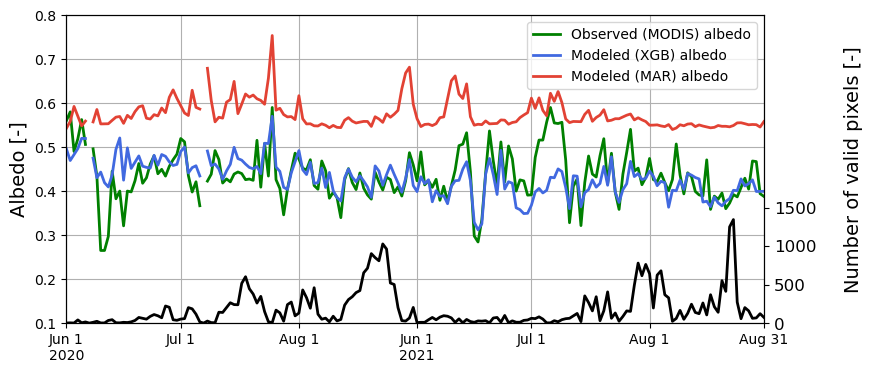

In [29]:
fig, ax1 = plt.subplots(figsize=(9,4))
ax2 = ax1.twinx()

ax1.plot(y_test_mean, color='g', label='Observed (MODIS) albedo', linewidth=2)
ax1.plot(y_test_pre_mean, color=[65/256, 105/256, 225/256], label='Modeled (XGB) albedo', linewidth=2)
ax1.plot(AL2_test_mean, color=[227/256, 66/256, 52/256], label='Modeled (MAR) albedo', linewidth=2)
ax1.set_ylabel('Albedo [-]', fontsize=14)
ax1.set_ylim([0.1, 0.8])
ax1.grid()
ax1.legend()
ax1.set_xticks([0,30,61,92,122,153,183])
ax1.set_xticklabels(['Jun 1\n2020', 'Jul 1', 'Aug 1', 'Jun 1\n2021', 'Jul 1', 'Aug 1', 'Aug 31', ])
ax1.set_xlim([0,183])

ax2.plot(y_num_nonan, 'k', linewidth=2)
ax2.set_ylabel('\nNumber of valid pixels [-]', fontsize=14)
ax2.set_ylim([0, 4000])
ax2.set_yticks([0, 500, 1000, 1500])
ax2.set_yticklabels(['0', '500', '1000', '1500'])

plt.tick_params(labelsize=12)

### Scatterplot

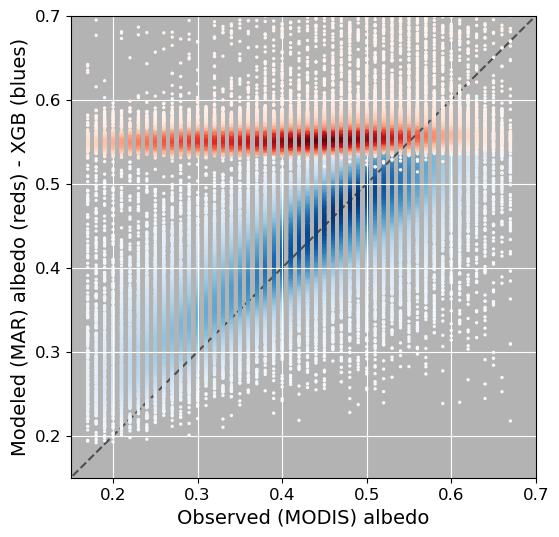

In [36]:
fig = plt.figure(figsize=(6,6))
ax = plt.gca()

# Calculate the point density
xy1 = np.vstack([y_test, y_test_pre])
z1 = gaussian_kde(xy1)(xy1)
xy2 = np.vstack([y_test, AL2_test])
z2 = gaussian_kde(xy2)(xy2)

plt.plot(np.arange(-1,100,1), np.arange(-1,100,1), color=[0.3, 0.3, 0.3], linestyle='--', linewidth=1.5, zorder=1)
plt.scatter(y_test, y_test_pre, c=z1, s=2, zorder=1, cmap='Blues')
plt.scatter(y_test, AL2_test, c=z2, s=2, zorder=2, cmap='Reds')

plt.xlabel('Observed (MODIS) albedo', fontsize=14)
plt.ylabel('Modeled (MAR) albedo (reds) - XGB (blues)', fontsize=14)
plt.grid(color='w', zorder=1)
ax.set_facecolor([0.7, 0.7, 0.7])
plt.tick_params(labelsize=12)
plt.xlim(0.15, 0.7);
plt.ylim(0.15, 0.7);

### Comparison maps

##### Put y_test_pre back into map-form for plotting

In [30]:
# only use MODIS albedo values within 2-sigma
y_masknan_test = np.where((y > y_meanminus2sig) & (y < y_meanplus2sig), 1, np.nan)
y_mask_test = y * y_masknan_test

In [31]:
# get all non-nan values in y (where bareice==1) and put them in a 1D array
y_nonan_test = y_mask_test[~np.isnan(y_mask_test)]

In [32]:
indices = np.where(~np.isnan(y_mask_test) == 1)

In [33]:
# the last 40920 data points (all data points in X_test and y_test) are spread over the last 200 days.
# put y_test_pre values in a matrix of shape (200,207,115) and then only use the last 184 days. otherwise the means are skewed towards august.
y_test_pre_vals = np.zeros((200,207,115))
AL2_test_vals = np.zeros((200,207,115))
for t in range(y_test_pre.shape[0]):
    y_test_pre_vals[indices[0][-40920+t]-1824, indices[1][-40920+t], indices[2][-40920+t]] = y_test_pre[t]
    AL2_test_vals[indices[0][-40920+t]-1824, indices[1][-40920+t], indices[2][-40920+t]] = AL2_test[t]

In [34]:
# only look at last two years (184 days). otherwise the mean is skewed towards august.
y_test_pre_plot = y_test_pre_vals[-184:,:,:]
AL2_test_plot = AL2_test_vals[-184:,:,:]

In [35]:
y_test_pre_plot = np.where(y_test_pre_plot == 0, np.nan, y_test_pre_plot)
AL2_test_plot = np.where(AL2_test_plot == 0, np.nan, AL2_test_plot)

In [36]:
y_test_pre_plot = y_test_pre_plot * y_masknan_test[-184:,:,:]
AL2_test_plot = AL2_test_plot * y_masknan_test[-184:,:,:]

In [37]:
n_lat_model = 207
n_lon_model = 115

/tmp/ipykernel_10197/2584878808.py:11: RuntimeWarning: Mean of empty slice
  p1 = ax1.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], np.nanmean(y_mask_test[-184:,:,:], 0), cmap=cmap, zorder=2, vmin=0.17, vmax=0.67, transform=ccrs.PlateCarree())
/tmp/ipykernel_10197/2584878808.py:16: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar1 = fig.colorbar(p1, fraction=0.035, pad=0.15)
/tmp/ipykernel_10197/2584878808.py:31: RuntimeWarning: Mean of empty slice
  p2 = ax2.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], np.nanmean(y_test_pre_plot, 0), cmap=cmap, zorder=2, vmin=0.17, vmax=0.67, transform=ccrs.PlateCarree())
/tmp/ipykernel_10197/2584878808.py:36: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get

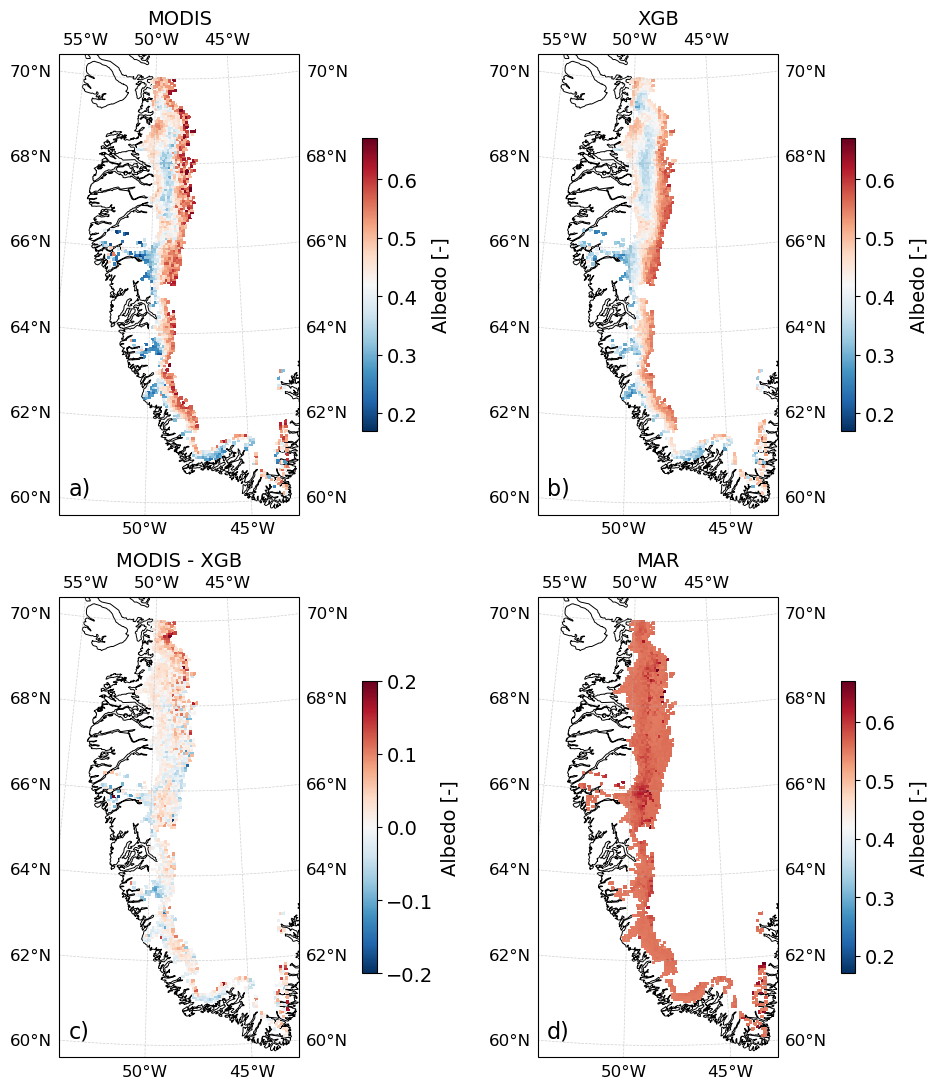

In [38]:
extent = [-54,-42.8,59.6,70.5]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

cmap = 'RdBu_r'
fig = plt.figure(figsize=(10, 11))

ax1 = plt.subplot(2,2,1, projection = ccrs.Orthographic(central_lon, central_lat))
ax1.set_extent(extent)
ax1.coastlines(resolution = '10m', linewidth=0.7, zorder=1)
p1 = ax1.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], np.nanmean(y_mask_test[-184:,:,:], 0), cmap=cmap, zorder=2, vmin=0.17, vmax=0.67, transform=ccrs.PlateCarree())

ax1.text(-290000, -540000, 'a)', fontsize=16)
ax1.set_title('MODIS', fontsize=14)

cbar1 = fig.colorbar(p1, fraction=0.035, pad=0.15)
cbar1.set_label('Albedo [-]', rotation=90, fontsize=14)
cbar1.ax.tick_params(labelsize = 14)
cbar1.ax.get_yaxis().labelpad = 10

gl1 = ax1.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', alpha=0.6, zorder=2)
gl1.xlocator = mticker.FixedLocator([-55, -50, -45])
gl1.xlabel_style = {'size': 12, 'color': 'black'}
gl1.ylocator = mticker.FixedLocator([60, 62, 64, 66, 68, 70])
gl1.ylabel_style = {'size': 12, 'color': 'black'}


ax2 = plt.subplot(2,2,2, projection = ccrs.Orthographic(central_lon, central_lat))
ax2.set_extent(extent)
ax2.coastlines(resolution = '10m', linewidth=0.7, zorder=1)
p2 = ax2.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], np.nanmean(y_test_pre_plot, 0), cmap=cmap, zorder=2, vmin=0.17, vmax=0.67, transform=ccrs.PlateCarree())

ax2.text(-290000, -540000, 'b)', fontsize=16)
ax2.set_title('XGB', fontsize=14)

cbar2 = fig.colorbar(p2, fraction=0.035, pad=0.15)
cbar2.set_label('Albedo [-]', rotation=90, fontsize=14)
cbar2.ax.tick_params(labelsize = 14)
cbar2.ax.get_yaxis().labelpad = 10

gl2 = ax2.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', alpha=0.6, zorder=2)
gl2.xlocator = mticker.FixedLocator([-55, -50, -45])
gl2.xlabel_style = {'size': 12, 'color': 'black'}
gl2.ylocator = mticker.FixedLocator([60, 62, 64, 66, 68, 70])
gl2.ylabel_style = {'size': 12, 'color': 'black'}


ax3 = plt.subplot(2,2,3, projection = ccrs.Orthographic(central_lon, central_lat))
ax3.set_extent(extent)
ax3.coastlines(resolution = '10m', linewidth=0.7, zorder=1)
p3 = ax3.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], np.nanmean(y_mask_test[-199:,:,:], 0) - np.nanmean(y_test_pre_plot, 0), cmap=cmap, zorder=2, vmin=-0.2 ,vmax=0.2, transform=ccrs.PlateCarree())

ax3.text(-290000, -540000, 'c)', fontsize=16)
ax3.set_title('MODIS - XGB', fontsize=14)

cbar3 = fig.colorbar(p3, fraction=0.035, pad=0.15)
cbar3.set_label('Albedo [-]', rotation=90, fontsize=14)
cbar3.ax.tick_params(labelsize = 14)
cbar3.ax.get_yaxis().labelpad = 5

gl3 = ax3.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', alpha=0.6, zorder=2)
gl3.xlocator = mticker.FixedLocator([-55, -50, -45])
gl3.xlabel_style = {'size': 12, 'color': 'black'}
gl3.ylocator = mticker.FixedLocator([60, 62, 64, 66, 68, 70])
gl3.ylabel_style = {'size': 12, 'color': 'black'}


ax4 = plt.subplot(2,2,4, projection = ccrs.Orthographic(central_lon, central_lat))
ax4.set_extent(extent)
ax4.coastlines(resolution = '10m', linewidth=0.7, zorder=1)
p4 = ax4.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], np.nanmean(AL2_test_plot[-199:,:,:], 0), cmap=cmap, zorder=2, vmin=0.17, vmax=0.67, transform=ccrs.PlateCarree())

ax4.text(-290000, -540000, 'd)', fontsize=16)
ax4.set_title('MAR', fontsize=14)

cbar4 = fig.colorbar(p4, fraction=0.035, pad=0.15)
cbar4.set_label('Albedo [-]', rotation=90, fontsize=14)
cbar4.ax.tick_params(labelsize = 14)
cbar4.ax.get_yaxis().labelpad = 10

gl4 = ax4.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', alpha=0.6, zorder=2)
gl4.xlocator = mticker.FixedLocator([-55, -50, -45])
gl4.xlabel_style = {'size': 12, 'color': 'black'}
gl4.ylocator = mticker.FixedLocator([60, 62, 64, 66, 68, 70])
gl4.ylabel_style = {'size': 12, 'color': 'black'}

plt.tight_layout()

### Histograms

Text(0.5, 1.0, 'XGB')

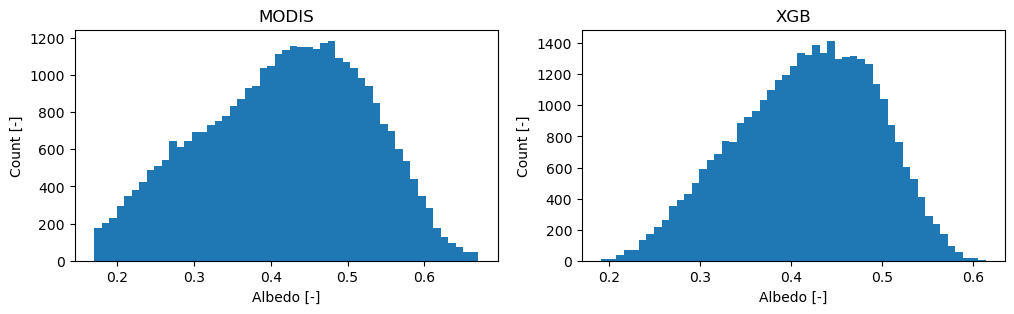

In [39]:
plt.figure(figsize=(12,3))

plt.subplot(1,2,1)
plt.hist(y_mask_test[-184:,:,:].flatten(), bins=51)
plt.xlabel('Albedo [-]')
plt.ylabel('Count [-]')
plt.title('MODIS')

plt.subplot(1,2,2)
plt.hist((y_test_pre_plot * y_masknan_test[-184:,:,:]).flatten(), bins=51)
plt.xlabel('Albedo [-]')
plt.ylabel('Count [-]')
plt.title('XGB')

## Number of bare ice occurrences

In [42]:
bareice_plot = np.nansum(bareice[-184:, :n_lat_model, :n_lon_model], 0)
bareice_plot = np.where(bareice_plot == 0, np.nan, bareice_plot)

/tmp/ipykernel_10197/2857640366.py:34: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar1 = fig.colorbar(p1, fraction=0.035, pad=0.2)


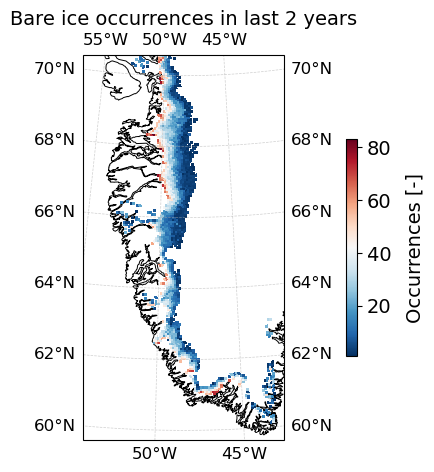

In [57]:
extent = [-54,-42.8,59.6,70.5]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig = plt.figure(figsize=(4, 5))

cmap = 'RdBu_r'

ax1 = plt.subplot(1,1,1, projection = ccrs.Orthographic(central_lon, central_lat))
ax1.set_extent(extent)
ax1.coastlines(resolution = '10m', linewidth=0.7, zorder=1)
p1 = ax1.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], bareice_plot, cmap=cmap, zorder=2, transform=ccrs.PlateCarree())

ax1.set_title('Bare ice occurrences in last 2 years', fontsize=14)

cbar1 = fig.colorbar(p1, fraction=0.035, pad=0.2)
cbar1.set_label('Occurrences [-]', rotation=90, fontsize=14)
cbar1.ax.tick_params(labelsize = 14)
cbar1.ax.get_yaxis().labelpad = 10

gl1 = ax1.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', alpha=0.6, zorder=2)
gl1.xlocator = mticker.FixedLocator([-55, -50, -45])
gl1.xlabel_style = {'size': 12, 'color': 'black'}
gl1.ylocator = mticker.FixedLocator([60, 62, 64, 66, 68, 70])
gl1.ylabel_style = {'size': 12, 'color': 'black'}

### Correlation map

In [ ]:
corrmap = np.zeros((n_lat_model, n_lon_model))
for i in range(corrmap.shape[0]):
    for j in range(corrmap.shape[1]):
        corrmap[i,j] = ma.corrcoef(ma.masked_invalid(y_mask_test[-184:,i,j]), ma.masked_invalid(y_test_pre_plot[:,i,j]))[1,0]

corrmap = corrmap**2

/tmp/ipykernel_10197/2421551500.py:35: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar1 = fig.colorbar(p1, fraction=0.035, pad=0.2)


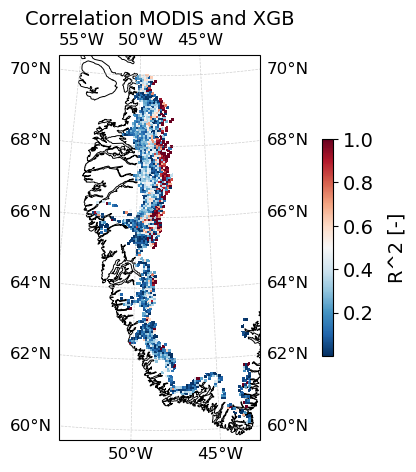

In [60]:
extent = [-54,-42.8,59.6,70.5]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig = plt.figure(figsize=(4, 5))

cmap = 'RdBu_r'

ax1 = plt.subplot(1,1,1, projection = ccrs.Orthographic(central_lon, central_lat))
ax1.set_extent(extent)
ax1.coastlines(resolution = '10m', linewidth=0.7, zorder=1)
p1 = ax1.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], corrmap, cmap=cmap, zorder=2, transform=ccrs.PlateCarree())

ax1.set_title('Correlation MODIS and XGB', fontsize=14)

cbar1 = fig.colorbar(p1, fraction=0.035, pad=0.2)
cbar1.set_label('R^2 [-]', rotation=90, fontsize=14)
cbar1.ax.tick_params(labelsize = 14)
cbar1.ax.get_yaxis().labelpad = 10

gl1 = ax1.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', alpha=0.6, zorder=2)
gl1.xlocator = mticker.FixedLocator([-55, -50, -45])
gl1.xlabel_style = {'size': 12, 'color': 'black'}
gl1.ylocator = mticker.FixedLocator([60, 62, 64, 66, 68, 70])
gl1.ylabel_style = {'size': 12, 'color': 'black'}

## Metrics: R2, Mean Squared Error (MSE), Mean Absolute Percentage Error (MAPE), Structural Similarity Index Measure (SSIM)

In [ ]:
im1_pixel = y_mask_test[-184:,:,:]
im2_pixel = y_test_pre_plot
im3_pixel = AL2_test_plot

im1_mean = np.nanmean(y_mask_test[-184:,:,:], 0)
im2_mean = np.nanmean(y_test_pre_plot, 0)
im3_mean = np.nanmean(AL2_test_plot, 0)

In [62]:
im1_pixel_flat = im1_pixel[~np.isnan(im1_pixel)].flatten()
im2_pixel_flat = im2_pixel[~np.isnan(im2_pixel)].flatten()
im3_pixel_flat = im3_pixel[~np.isnan(im3_pixel)].flatten()

im1_mean_flat = im1_mean[~np.isnan(im1_mean)].flatten()
im2_mean_flat = im2_mean[~np.isnan(im2_mean)].flatten()
im3_mean_flat = im3_mean[~np.isnan(im3_mean)].flatten()

In [63]:
# MODIS-MAR metrics for pixel-by-pixel
R2_pixel = ma.corrcoef(im1_pixel_flat, im3_pixel_flat)[1,0]**2
mse_pixel = mean_squared_error(im1_pixel_flat, im3_pixel_flat)
mape_pixel = mean_absolute_percentage_error(im1_pixel_flat, im3_pixel_flat)
ssim_pixel = ssim(im1_pixel_flat, im3_pixel_flat, data_range=im3_pixel_flat.max() - im3_pixel_flat.min())

R2_pixel, mse_pixel, mape_pixel, ssim_pixel

(0.05317252036867819,
 0.031181055671180236,
 0.45932836216627776,
 0.08255634608834857)

In [64]:
# MODIS-XGB metrics for pixel-by-pixel
R2_pixel = ma.corrcoef(im1_pixel_flat, im2_pixel_flat)[1,0]**2
mse_pixel = mean_squared_error(im1_pixel_flat, im2_pixel_flat)
mape_pixel = mean_absolute_percentage_error(im1_pixel_flat, im2_pixel_flat)
ssim_pixel = ssim(im1_pixel_flat, im2_pixel_flat, data_range=im2_pixel_flat.max() - im2_pixel_flat.min())

R2_pixel, mse_pixel, mape_pixel, ssim_pixel

(0.5198841148969371,
 0.005697917912507653,
 0.15294823136356434,
 0.5949014311556067)

# SHAP

#### The SHAP value of each feature represents the impact that feature has on ice albedo. So, a positive SHAP value of 0.1 for surface height means that albedo is increased by 0.1, purely due to the surface height of the ice sheet.

In [65]:
explainer = shap.TreeExplainer(bst, X_train)

#### For last n points in X_train

In [37]:
shap_values = explainer(X_train[:])

In [38]:
# pickle.dump(shap_values, open('shap_values.sav', 'wb'))

In [66]:
# shap_values = pickle.load(open('shap_values.sav', 'rb'))

#### Create shap_values_data by de-standardizing the data values. This should be the same as X_train

In [67]:
shap_values_data = (shap_values.data * vars_std) + vars_mean

## Visualization 

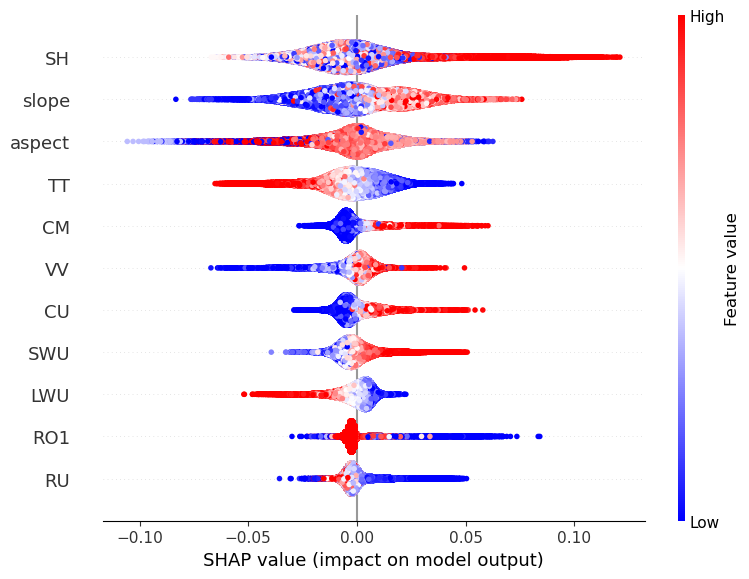

In [68]:
shap.summary_plot(shap_values[:,[0,1,2,4,9,10,12,14,19,20,21]], cmap='bwr', feature_names = ['TT', 'RU', 'SWU', 'LWU', 'CM', 'CU', 'RO1', 'VV', 'SH', 'slope', 'aspect'], plot_type='dot')

### Plot SHAP values on map

In [69]:
# only use MODIS albedo values within 2-sigma
y_masknan_test = np.where((y > y_meanminus2sig) & (y < y_meanplus2sig), 1, np.nan)
y_mask_test = y * y_masknan_test

In [70]:
# get all non-nan values in y (where bareice==1) and put them in a 1D array
y_nonan_test = y_mask_test[~np.isnan(y_mask_test)]

In [71]:
indices = np.where(~np.isnan(y_mask_test) == 1)

In [72]:
firstindex = 40920+40919 # size of X_val + X_test
firstday = indices[0][-firstindex-shap_values.shape[0]]
shap_values_vals = np.zeros((1629,207,115,shap_values.shape[1]))
X_train_vals = np.zeros((1629,207,115,shap_values.shape[1]))

for f in range(shap_values_vals.shape[3]):
    for t in range(shap_values.shape[0]):
        shap_values_vals[indices[0][-firstindex-shap_values.shape[0]+t]-firstday, indices[1][-firstindex-shap_values.shape[0]+t], indices[2][-firstindex-shap_values.shape[0]+t], f] = shap_values.values[t,f]
        X_train_vals[indices[0][-firstindex-shap_values.shape[0]+t]-firstday, indices[1][-firstindex-shap_values.shape[0]+t], indices[2][-firstindex-shap_values.shape[0]+t], f] = X_train[-shap_values.shape[0]+t,f]

In [73]:
# for day 1628 (last day), not the entire day is predicted by XGB, only a couple of points. this is due to the 'arbitrary' cutoff of 2/22 I use in train_test_split
# therefore, cut off the last day
shap_values_plot = shap_values_vals[:-1,:,:]
X_train_plot = X_train_vals[:-1,:,:]

In [74]:
shap_values_plot = np.where(shap_values_plot == 0, np.nan, shap_values_plot)
X_train_plot = np.where(X_train_plot == 0, np.nan, X_train_plot)

/tmp/ipykernel_10197/1603275124.py:16: RuntimeWarning: Mean of empty slice
  p1 = ax1.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], (np.nanmean(X_train_plot[:,:,:,feat], 0) * vars_std[feat]) + vars_mean[feat],
/tmp/ipykernel_10197/1603275124.py:21: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar1 = fig.colorbar(p1, fraction=0.035, pad=0.1)
/tmp/ipykernel_10197/1603275124.py:39: RuntimeWarning: Mean of empty slice
  p2 = ax2.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], np.nanmean(shap_values_plot[:,:,:,feat], 0),
/tmp/ipykernel_10197/1603275124.py:44: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar2 = fig.color

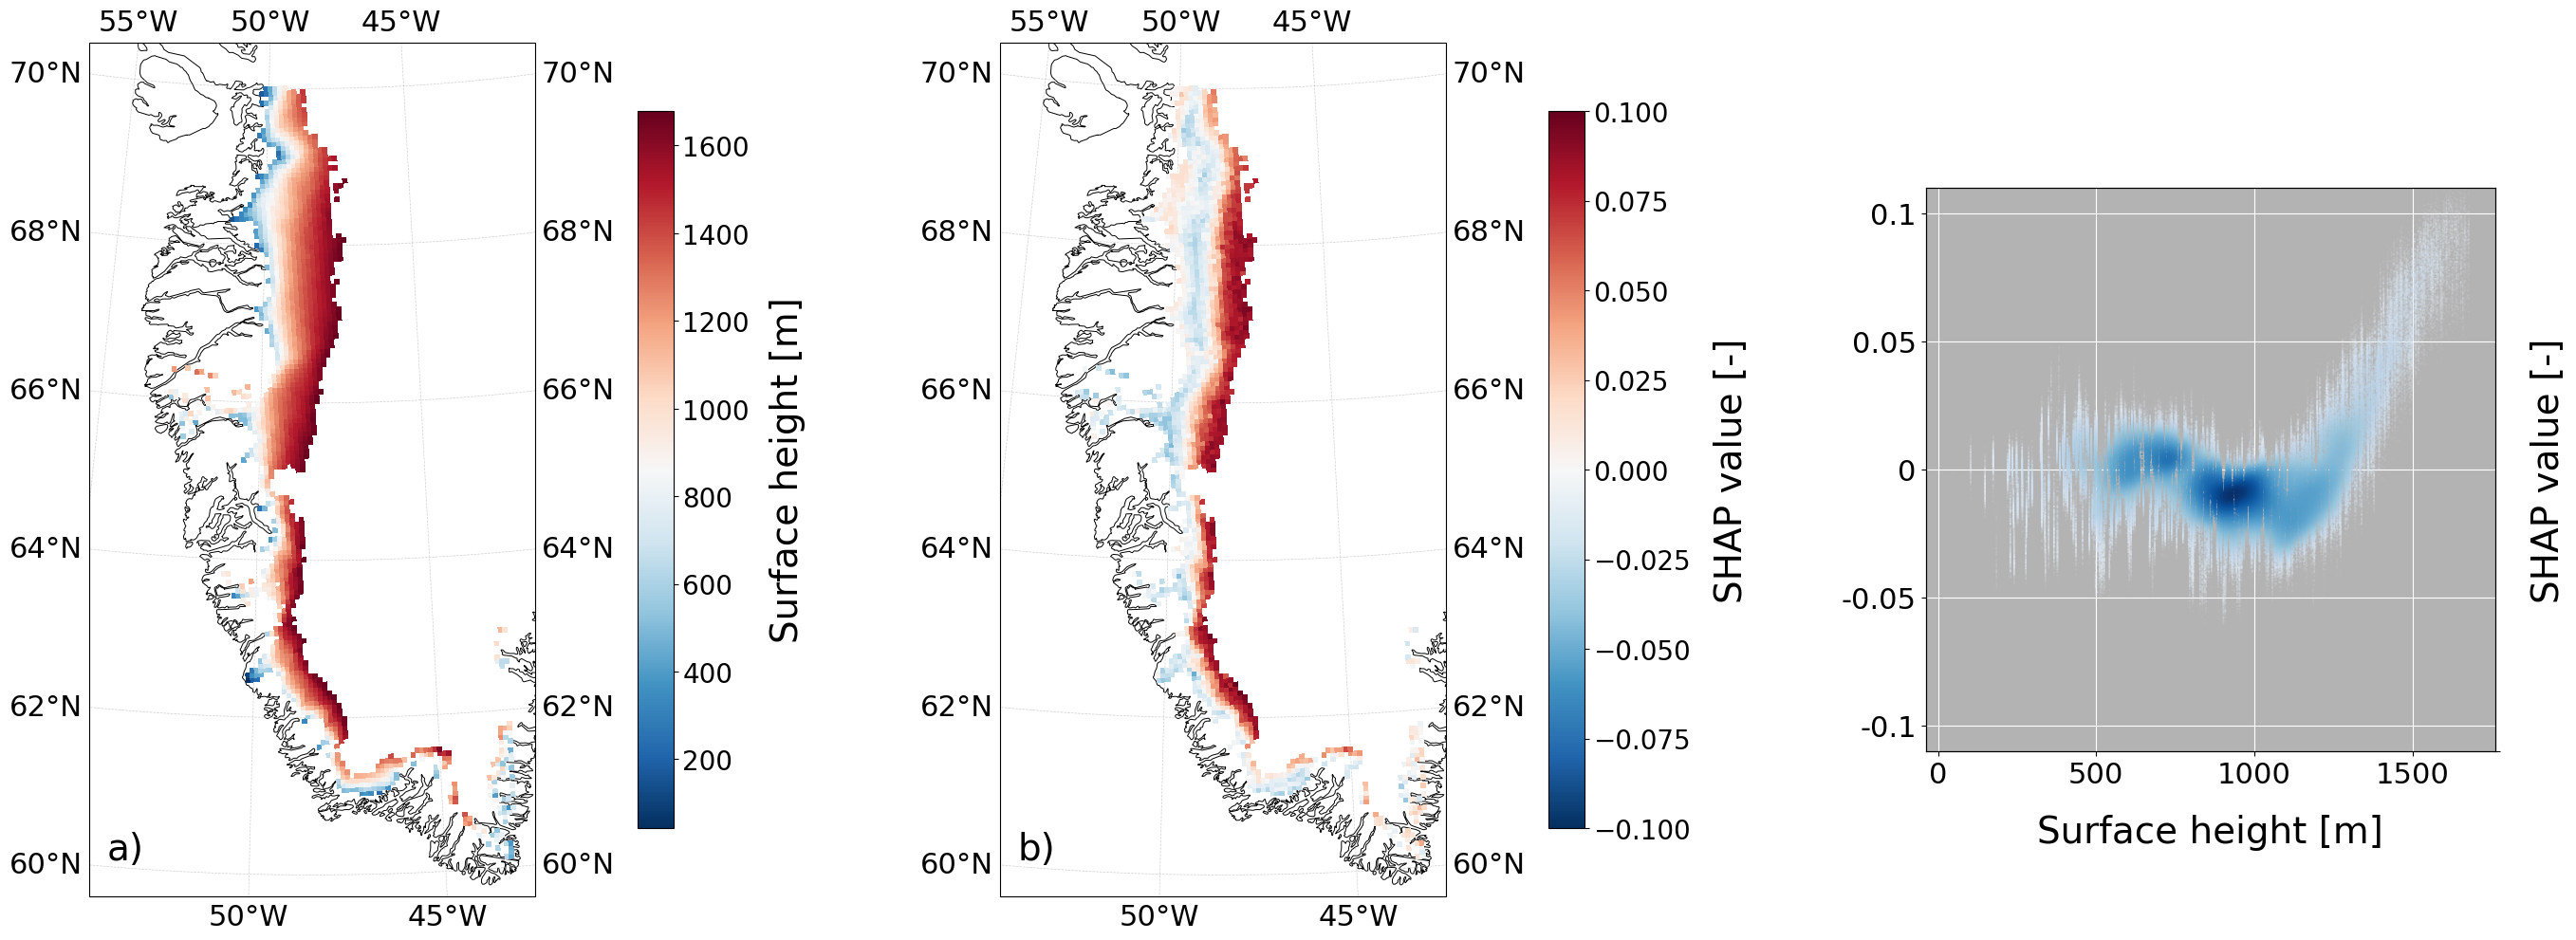

In [78]:
extent = [-54,-42.8,59.6,70.5]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

cmap = 'RdBu_r'
feat = 19

fig = plt.figure(figsize=(30,9))


# ax1
ax1 = fig.add_axes([0, 0, 0.36, 1], projection = ccrs.Orthographic(central_lon, central_lat))

ax1.set_extent(extent)
ax1.coastlines(resolution = '10m', linewidth=0.7, zorder=1)
p1 = ax1.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], (np.nanmean(X_train_plot[:,:,:,feat], 0) * vars_std[feat]) + vars_mean[feat],
                cmap=cmap, zorder=3, transform=ccrs.PlateCarree())

ax1.text(-290000, -540000, 'a)', fontsize=28)

cbar1 = fig.colorbar(p1, fraction=0.035, pad=0.1)
cbar1.set_label('Surface height [m]', rotation=90, fontsize=28)
cbar1.ax.tick_params(labelsize = 20)
cbar1.ax.get_yaxis().labelpad = 15

gl1 = ax1.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', alpha=0.6, zorder=2)
gl1.xlocator = mticker.FixedLocator([-55, -50, -45])
gl1.xlabel_style = {'size': 22, 'color': 'black'}
gl1.ylocator = mticker.FixedLocator([60, 62, 64, 66, 68, 70])
gl1.ylabel_style = {'size': 22, 'color': 'black'}


# ax2
ax2 = fig.add_axes([0.32, 0, 0.36, 1], projection = ccrs.Orthographic(central_lon, central_lat))

ax2.set_extent(extent)
ax2.coastlines(resolution = '10m', linewidth=0.7, zorder=1)

p2 = ax2.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], np.nanmean(shap_values_plot[:,:,:,feat], 0),
                cmap=cmap, zorder=3, transform=ccrs.PlateCarree(), vmin=-0.1, vmax=0.1)

ax2.text(-290000, -540000, 'b)', fontsize=28)

cbar2 = fig.colorbar(p2, fraction=0.035, pad=0.1)
cbar2.set_label('SHAP value [-]', rotation=90, fontsize=28)
cbar2.ax.tick_params(labelsize = 20)
cbar2.ax.get_yaxis().labelpad = 17

gl2 = ax2.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', alpha=0.6, zorder=2)
gl2.xlocator = mticker.FixedLocator([-55, -50, -45])
gl2.xlabel_style = {'size': 22, 'color': 'black'}
gl2.ylocator = mticker.FixedLocator([60, 62, 64, 66, 68, 70])
gl2.ylabel_style = {'size': 22, 'color': 'black'}


# ax3
ax3 = fig.add_axes([0.80, 0.17, 0.2, 0.66])
ax3.yaxis.tick_right()
ax4 = ax3.twinx()

ndp = 200000

# Calculate the point density
xy3 = np.vstack([shap_values_data[-ndp:,feat], shap_values.values[-ndp:,feat]])
z3 = gaussian_kde(xy3)(xy3)

ax3.scatter(shap_values_data[-ndp:,feat], shap_values.values[-ndp:,feat], s=z3, zorder=2, c=z3, cmap='Blues')
ax3.set_facecolor([0.7, 0.7, 0.7])
ax3.grid(color='w', zorder=1)
ax3.set_ylim(-0.11, 0.11);

ax3.set_xlabel('Surface height [m]', fontsize=28, labelpad=20)
ax4.set_ylabel('SHAP value [-]', fontsize=28, labelpad=20)
ax3.tick_params(labelsize=22)
ax3.set_yticks([-0.1, -0.05, 0, 0.05, 0.1]);
ax3.set_yticklabels(['-0.1', '-0.05', '0', '0.05', '0.1']);
ax4.set_yticks([0]);
ax4.set_yticklabels(['']);

fig.tight_layout()
plt.show()

#### Linear regression of temperature (TT) vs SHAP value of TT

In [79]:
lin_reg = LinearRegression()
lin_reg.fit(shap_values_data[-50000:,0].reshape(-1,1), shap_values.values[-50000:,0].reshape(-1,1))
c_slope = lin_reg.coef_[0]
c_intercept = lin_reg.intercept_

c_slope, c_intercept

(array([-0.00576782]), array([0.00911616]))

## Correlations between variables

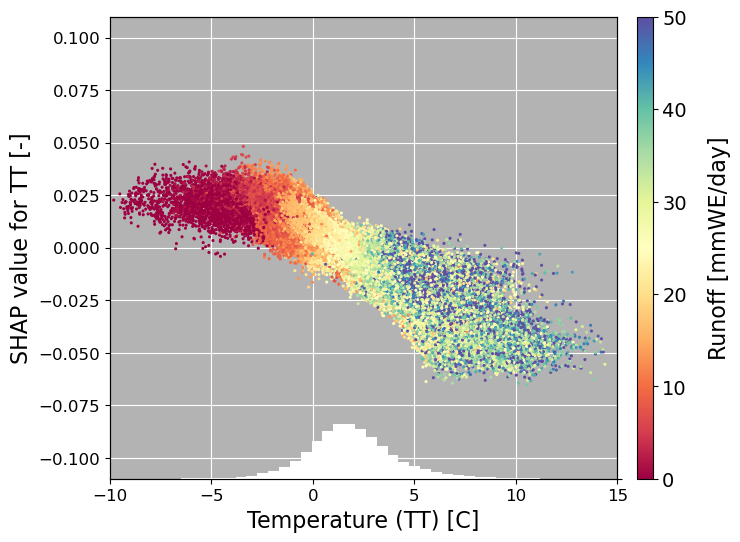

In [497]:
feat = 0
feat_color = 1
ndp = -0 # -0 means plot all points

fig, ax1 = plt.subplots(figsize=(7,6))
ax2 = ax1.twinx()

sp = ax1.scatter(shap_values_data[-ndp:,feat], shap_values.values[-ndp:,feat], s=z1, zorder=2,
            c=shap_values_data[-ndp:,feat_color], cmap='Spectral', vmin=0, vmax=50)
ax1.set_facecolor([0.7, 0.7, 0.7])
ax1.grid(color='w', zorder=1)
ax1.set_xlim(-10, 15);
ax1.set_ylim(-0.11, 0.11);

ax1.set_xlabel('Temperature (TT) [C]', fontsize=16)
ax1.set_ylabel('SHAP value for TT [-]', fontsize=16)
ax1.tick_params(labelsize=12)

ax2.hist(shap_values_data[-ndp:, feat], color='w', bins=50)
ax2.set_ylim([0, 350000])
ax2.set_yticks([0]);
ax2.set_yticklabels(['']);

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='3%', pad=0.2)
cbar = fig.colorbar(sp, cax=cax, orientation='vertical')
cbar.set_label('Runoff [mmWE/day]', rotation=90, fontsize=16)
cbar.ax.tick_params(labelsize=14)
cbar.ax.get_yaxis().labelpad = 15

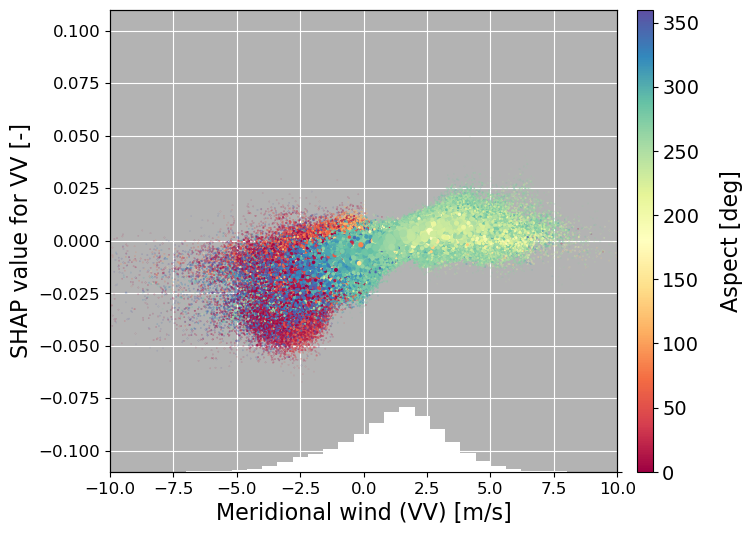

In [98]:
feat = 14
feat_color = 21
ndp = -0 # -0 means plot all points

fig, ax1 = plt.subplots(figsize=(7,6))
ax2 = ax1.twinx()

# Calculate the point density
xy1 = np.vstack([shap_values_data[-ndp:,feat], shap_values.values[-ndp:,feat]])
z1 = gaussian_kde(xy1)(xy1)

sp = ax1.scatter(shap_values_data[-ndp:,feat], shap_values.values[-ndp:,feat], s=z1, zorder=2, #s=1.5
            c=shap_values_data[-ndp:,feat_color], cmap='Spectral', vmin=0, vmax=360)
ax1.set_facecolor([0.7, 0.7, 0.7])
ax1.grid(color='w', zorder=1)
ax1.set_xlim(-10, 10);
ax1.set_ylim(-0.11, 0.11);

ax1.set_xlabel('Meridional wind (VV) [m/s]', fontsize=16)
ax1.set_ylabel('SHAP value for VV [-]', fontsize=16)
ax1.tick_params(labelsize=12)

ax2.hist(shap_values_data[-ndp:, feat], color='w', bins=50)
ax2.set_ylim([0, 350000])
ax2.set_yticks([0]);
ax2.set_yticklabels(['']);

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='3%', pad=0.2)
cbar = fig.colorbar(sp, cax=cax, orientation='vertical')
cbar.set_label('Aspect [deg]', rotation=90, fontsize=16)
cbar.ax.tick_params(labelsize=14)
cbar.ax.get_yaxis().labelpad = 15